In [2]:
# imports and loading
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from pymodulon.io import *
from os import path
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import numpy as np

interim_dir = path.join('..','data','interim')
ica_data = load_json_model(path.join(interim_dir,'zmo_raw.json.gz'))
proteomics_df = pd.read_excel('../data/external/proteomics_10_3389_fmicb_2019_02596.XLSX', sheet_name = 'LFQ', index_col = 0)
metab_df = pd.read_excel('../data/external/metabolomics_10_3389_fmicb_2019_02596.XLSX', index_col = 0)
metab_df = metab_df.set_index('Metabolite').drop(columns = 'DCW = dry cell weight')

# mid-glucose (T1, about 50% glucose utilized)
# late glucose (T2, about 5–10 g glucose/L remaining)
# early xylose (T3, ∼1 h after glucose was completely depleted)
# late xylose (T4, ∼24 h after glucose was completely depleted)
# let's focus on SynH3- samples, as I'm not particularlly interested in stressors
column_to_sample = {
    'LDI_early_glucose_fold_change' : 'lignocellulose_ferment:high_ACSH_early',
    'LDI_late_glucose_fold_change' : 'lignocellulose_ferment:high_ACSH_mid',
    'LDI_early_xylose_fold_change' : 'lignocellulose_ferment:high_ACSH_late',
    'LDI_late_xylose_fold_change' : 'lignocellulose_ferment:high_ACSH_stat',
    'no_LDI_early_glucose_fold_change' : 'lignocellulose_ferment:low_ACSH_early',
    'no_LDI_late_glucose_fold_change' : 'lignocellulose_ferment:low_ACSH_mid',
    'no_LDI_early_xylose_fold_change' : 'lignocellulose_ferment:low_ACSH_late',
    'no_LDI_late_xylose_fold_change' : 'lignocellulose_ferment:low_ACSH_stat',
}


sample_X_df = pd.DataFrame(index = ica_data.X.index)
for group_id, group_df in ica_data.sample_table.groupby('full_name'):
    sample_X_df[group_id] = ica_data.X[group_df.index].T.mean()


pentose_phosphate_pathway = 'map00030'




###############################
# modify proteomics dataframe #
###############################
col_opts = ['SynH3- T1', 'SynH3- T2', 'SynH3- T3', 'SynH3- T4', 
            'SynH3 T1', 'SynH3 T2', 'SynH3 T3', 'SynH3 T4'
            ]
control_cols = ['SynH3- T1', 'SynH3 T1']
opt_to_name = {
    'SynH3- T1' : 'LDI_early_glucose_fold_change',
    'SynH3- T2' : 'LDI_late_glucose_fold_change',
    'SynH3- T3' : 'LDI_early_xylose_fold_change',
    'SynH3- T4' : 'LDI_late_xylose_fold_change', 
    'SynH3 T1' : 'no_LDI_early_glucose_fold_change',
    'SynH3 T2' : 'no_LDI_late_glucose_fold_change',
    'SynH3 T3' : 'no_LDI_early_xylose_fold_change',
    'SynH3 T4' : 'no_LDI_late_xylose_fold_change',
}

# find overlap between ICA genes and proteomics data
#proteomics_df = proteomics_df.loc[genes]
proteomics_df = proteomics_df  / proteomics_df.sum() # standardize by sample

# let's create the standards
col_to_std = {}
proteome_fold_change_df = pd.DataFrame(index = proteomics_df.index)
for col in control_cols:
    cols_use = [col+' Rep1', col+' Rep2', col+' Rep3']
    meaned_df = proteomics_df[cols_use].mean(axis = 1)
    col_to_std.update({col.split(' ')[0] : meaned_df})
for col in col_opts:
    control = col.split(' ')[0]
    cols_use = [col+' Rep1', col+' Rep2', col+' Rep3']
    meaned_df = proteomics_df[cols_use].mean(axis = 1)
    fold_change = (meaned_df / col_to_std[control])
    proteome_fold_change_df[opt_to_name[col]] = np.log2(fold_change)


#################################
# modify metabolomics dataframe #
#################################
# metabolites data processing
code_to_df_name = {
    'g6p_c' : 'Glucose 6-phosphate',
    '6pgc_c' : '6-phosphogluconate', 
    'f6p_c' : 'Fructose 6-phosphate',
    'xu5p__D_c' : 'Xylulose 5-phosphate',
    'r5p_c' : 'Ribose 5-phosphate', 
    'ru5p__D_c' : 'Ribulose 5-phosphate',
    's7p_c' : 'Sedoheptulose 7-phosphate',
    'e4p_c' : 'Erythrose 4-phosphate',
    'g3p_c' : 'Glycerol 3-phosphate', 
}
external = [
    'Glucose',
    'Xylose'
]

# let's pull out xylose processing genes
metabs = list(code_to_df_name.values())
col_opts = ['SynH-LDI T1', 'SynH-LDI T2', 'SynH-LDI T3', 'SynH-LDI T4', 
            'SynH+LDI T1', 'SynH+LDI T2', 'SynH+LDI T3', 'SynH+LDI T4'
            ]
control_cols = ['SynH-LDI T1', 'SynH+LDI T1']
opt_to_name = {
    'SynH-LDI T1' : 'LDI_early_glucose_fold_change',
    'SynH-LDI T2' : 'LDI_late_glucose_fold_change',
    'SynH-LDI T3' : 'LDI_early_xylose_fold_change',
    'SynH-LDI T4' : 'LDI_late_xylose_fold_change', 
    'SynH+LDI T1' : 'no_LDI_early_glucose_fold_change',
    'SynH+LDI T2' : 'no_LDI_late_glucose_fold_change',
    'SynH+LDI T3' : 'no_LDI_early_xylose_fold_change',
    'SynH+LDI T4' : 'no_LDI_late_xylose_fold_change',
}

# find overlap between ICA genes and proteomics data
metab_df = metab_df  / metab_df.sum() # standardize by sample

# let's create the standards
col_to_std = {}
metab_fold_change_df = pd.DataFrame(index = metab_df.index)
for col in control_cols:
    cols_use = [col+' rep1', col+' rep2', col+' rep3']
    meaned_df = metab_df[cols_use].mean(axis = 1)
    col_to_std.update({col.split(' ')[0] : meaned_df})
for col in col_opts:
    control = col.split(' ')[0]
    cols_use = [col+' rep1', col+' rep2', col+' rep3']
    meaned_df = metab_df[cols_use].mean(axis = 1)
    fold_change = (meaned_df / col_to_std[control])
    metab_fold_change_df[opt_to_name[col]] = np.log2(fold_change)

# proteome panel of PPP genes

In [46]:
# options
nitrogen_genes = [
    'ZCP4_1183', 'ZCP4_0790', 'ZCP4_0614', 'ZCP4_0397', 
    'ZCP4_0127', 'ZCP4_1693', 'ZCP4_1508', 'ZCP4_1358', 
    'ZCP4_1350'
]
# pulled by looking at KEGG maps mostly
PPP_genes = [
    'ZCP4_0122', 'ZCP4_1667', 'ZCP4_1066', 'ZCP4_1199', 
    'ZCP4_0134', 'ZCP4_1069', 'ZCP4_0905', 
]
xylose_to_g3p_genes = [
    'ZCP4_1069', 'ZCP4_0134', 'ZCP4_1066', 'ZCP4_0801', 
]

gene_to_label = {
    'ZCP4_0122' : 'glucose-6p to fructose-6p',
    'ZCP4_1667' : 'frutose-6p to frutcose-1,6p AND \n glucono-1,5-lactone-6p to gluconolactone-6p',
    'ZCP4_1066' : 'frutcose-1,6p to g3p',
    'ZCP4_1199' : 'xylulose-5p to ribulose-5p',
    'ZCP4_0134' : 'ribulose-5p to ribose-5p',
    'ZCP4_1069' : 'ribose-5p to g3p',
    'ZCP4_0905' : 'glucose-6p to glucono-1,5-lactone-6p', # the pathway from this to D-ribulose seems to be lacking in Zymomonas, I'm guessing this won't run much in xylose
}

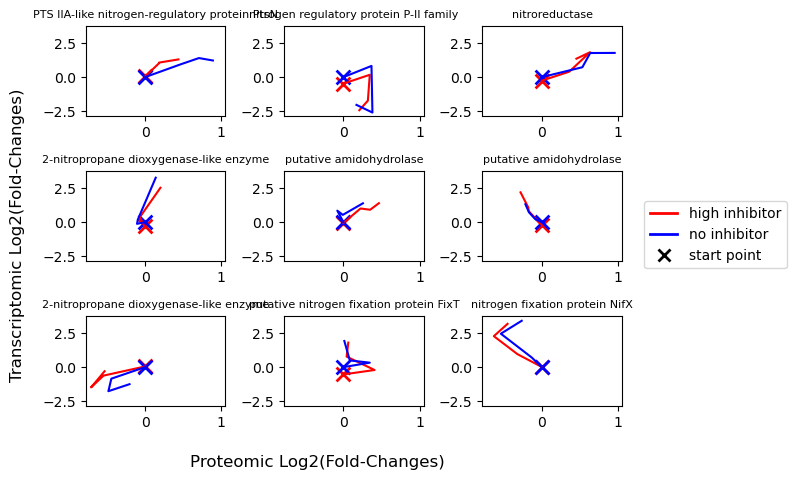

In [47]:
# settings
plot_genes = nitrogen_genes

fig, axs = plt.subplots(3,3)
ax_iter = iter(axs.flatten())
max_x = 0
min_x = 0
max_y = 0
min_y = 0
for gene in plot_genes:
    ax = next(ax_iter)
    # let's look at expression, iM activity, and proteomics of the genes in question
    #prot_index = ica_data.gene_table.loc[gene].ZM4_locus.split('_')[1]
    gene_changes = np.log2(2**sample_X_df[column_to_sample.values()].loc[gene] / 2**sample_X_df['lignocellulose_ferment:low_ACSH_early'].loc[gene])
    prot_changes = np.log2(ica_data.gene_table.loc[gene][column_to_sample.keys()].astype(float).rename(index = column_to_sample))
    #proteomics_df.loc[prot_index].rename(index = column_to_sample)
    
    order_1 = [
        'lignocellulose_ferment:high_ACSH_early', 
        'lignocellulose_ferment:high_ACSH_mid', 
        'lignocellulose_ferment:high_ACSH_late', 
        'lignocellulose_ferment:high_ACSH_stat',
    ]
    order_2 = [
        'lignocellulose_ferment:low_ACSH_early', 
        'lignocellulose_ferment:low_ACSH_mid', 
        'lignocellulose_ferment:low_ACSH_late', 
        'lignocellulose_ferment:low_ACSH_stat'
    ]
    if gene in gene_to_label:
        label = gene_to_label[gene]
    else:
        label = ica_data.gene_table.loc[gene].gene_product
    ax.set_title(label, fontsize = 8)
    ax.scatter(prot_changes.loc[order_1][0], gene_changes.loc[order_1][0], c = 'red', marker = 'x', lw = 2, s = 100)
    ax.scatter(prot_changes.loc[order_2][0], gene_changes.loc[order_2][0], c = 'blue', marker = 'x', lw = 2, s = 100)
    ax.plot(prot_changes.loc[order_1], gene_changes.loc[order_1], c = 'red', label = 'high_ACSH')
    ax.plot(prot_changes.loc[order_2], gene_changes.loc[order_2], c = 'blue', label = 'low_ACSH')
    if min(prot_changes.loc[order_1+order_2]) < min_x:
        min_x = min(prot_changes.loc[order_1+order_2])
    if max(prot_changes.loc[order_1+order_2]) > max_x:
        max_x = max(prot_changes.loc[order_1+order_2])
    if min(gene_changes.loc[order_1+order_2]) < min_y:
        min_y = min(gene_changes.loc[order_1+order_2])
    if max(gene_changes.loc[order_1+order_2]) > max_y:
        max_y = max(gene_changes.loc[order_1+order_2])
for ax in axs.flatten():
    ax.set_xlim([1.1*min_x, 1.1*max_x])
    ax.set_ylim([1.1*min_y, 1.1*max_y])
    
fig.supxlabel('Proteomic Log2(Fold-Changes)')
fig.supylabel('Transcriptomic Log2(Fold-Changes)')

# Create custom legend elements using Line2D and Patch
legend_handles = [
    Line2D([0], [0], color='red', lw=2, label='high inhibitor'),
    Line2D([0], [0], color='blue', lw=2, label='no inhibitor'),
    Line2D([0], [0], color='black', lw=0, marker='x', markersize=8, markeredgewidth=2, label='start point')
]
patch = Patch(color='yellow', label='Custom Patch')  # Example of a patch in the legend

# Combine the line and patch objects into a single legend
fig.legend(handles = legend_handles, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig('../figures/xylose_story_panel.pdf', transparent = True)
plt.show()

# create and save legend
plt.figure()
plt.legend(handles = legend_handles, loc='center')
plt.savefig('../figures/xylose_story_panel_legend.pdf', transparent = True)
plt.close()

# checking metabolite concentrations

In [142]:
# metabolites data processing
code_to_df_name = {
    'g6p_c' : 'Glucose 6-phosphate',
    '6pgc_c' : '6-phosphogluconate', 
    'f6p_c' : 'Fructose 6-phosphate',
    'xu5p__D_c' : 'Xylulose 5-phosphate',
    'r5p_c' : 'Ribose 5-phosphate', 
    'ru5p__D_c' : 'Ribulose 5-phosphate',
    's7p_c' : 'Sedoheptulose 7-phosphate',
    'e4p_c' : 'Erythrose 4-phosphate',
    'g3p_c' : 'Glycerol 3-phosphate', 
}
external = [
    'Glucose',
    'Xylose'
]
LDI_samples = [
    'LDI_early_glucose_fold_change', 'LDI_late_glucose_fold_change', 
    'LDI_early_xylose_fold_change', 'LDI_late_xylose_fold_change', 
]
no_LDI_samples = [
    'no_LDI_early_glucose_fold_change', 'no_LDI_late_glucose_fold_change', 
    'no_LDI_early_xylose_fold_change', 'no_LDI_late_xylose_fold_change'
]

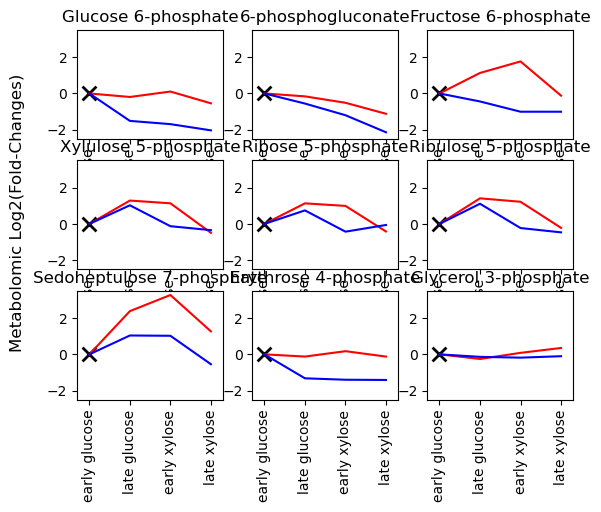

In [52]:
# plotting metabolites

fig, axs = plt.subplots(3,3)
ax_iter = iter(axs.flatten())
for metab in metabs:
    ax = next(ax_iter)
    ax.plot([0, 1, 2, 3], metab_fold_change_df.loc[metab][LDI_samples], c = 'red')
    ax.plot([0, 1, 2, 3], metab_fold_change_df.loc[metab][no_LDI_samples], c = 'blue')
    ax.scatter([0], [0], c = 'black', marker = 'x', lw = 2, s = 100)
    ax.set_xticks([0, 1, 2, 3], labels = ['early glucose', 'late glucose', 'early xylose', 'late xylose'], rotation = 90)
    ax.set_title(metab)
    ax.set_xlim([-.3, 3.3])
    ax.set_ylim([-2.5, 3.5])

fig.supylabel('Metabolomic Log2(Fold-Changes)')
#plt.tight_layout()
plt.savefig('../figures/metab_changes.pdf', transparent = True)
plt.show()

# let's look at the fold changes for eco genes (no expression data easily available)

In [54]:
proteome_fold_change_df.loc[['b0008', 'b2935']]

,LDI_early_glucose_fold_change,LDI_late_glucose_fold_change,LDI_early_xylose_fold_change,LDI_late_xylose_fold_change,no_LDI_early_glucose_fold_change,no_LDI_late_glucose_fold_change,no_LDI_early_xylose_fold_change,no_LDI_late_xylose_fold_change
Protein Group,,,,,,,,
b0008,0.0,0.190531,0.140122,0.064946,0.0,0.173182,0.101456,0.069086
b2935,0.0,0.114478,0.078170,0.002294,0.0,0.104295,0.088819,-0.075374
